In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')
        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i]['true'], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')


        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [4]:
### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = [200, 250],
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = [200,250],
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/home/fire/SAMMY/sammy/build/install/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)


cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [5]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT()
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=2)

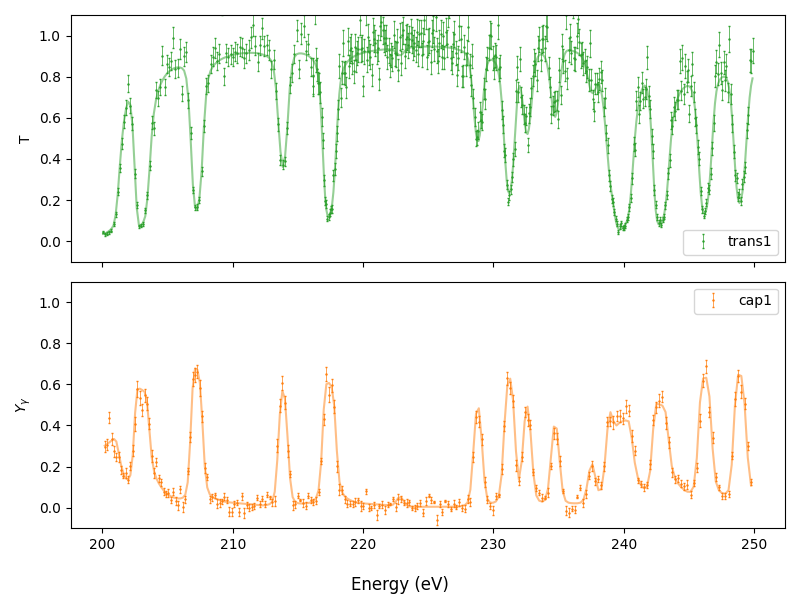

In [6]:
### unpack sample and plot

sample1 = syndat.get_sample(1)

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

fig = plot(datasets, experiments, fits=[], priors=[], true=datasets)
fig.tight_layout()

In [7]:
Ta_pair.spin_groups['3.0']

{'J_ID': 1,
 '<D>': 8.79,
 '<Gn>': 46.5,
 'n_dof': 1,
 '<Gg>': 64.0,
 'g_dof': 1000,
 'D01': 0.9943384234177864,
 'D99': 21.284662911191237,
 'Gn01': 0.007304585392801135,
 'Gn99': 308.52269194748646,
 'Gg01': 57.53039660349525,
 'Gg99': 70.84601563854191,
 'Gt01': 57.53770118888805,
 'Gt99': 379.3687075860284}

In [8]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT


sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/home/fire/SAMMY/sammy/build/install/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1)
autofit_initial = InitialFB(options)

In [9]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [92.9533, 657.259, 750.2123]
1    0.75 : [23.2418, 123.63, 146.8718]
2    1.125: [40.0702, 14.2516, 54.3218]
Repeat step 3, 	fudge: ['cap1', 'trans1', 'sum']
		0.225: [30.0714, 11.2643, 41.3357]
3    0.225: [30.0714, 11.2643, 41.3357]
4    0.338: [18.2302, 9.0528, 27.283]
5    0.506: [17.7364, 9.0847, 26.8211]
Repeat step 6, 	fudge: ['cap1', 'trans1', 'sum']
		0.101: [16.5808, 9.6925, 26.2733]
6    0.101: [16.5808, 9.6925, 26.2733]
7    0.152: [15.8601, 9.589, 25.4492]
8    0.228: [14.5705, 9.6245, 24.195]
9    0.342: [13.8952, 9.5773, 23.4725]
10    0.513: [13.6569, 9.4858, 23.1427]
11    0.769: [13.4914, 9.3998, 22.8912]
12    1.153: [13.3516, 9.3282, 22.6798]
13    1.73 : [13.4337, 9.1782, 22.6119]
Chi2 improvement below threshold

----------------------------------------
Eliminated 54.03% of resonance features based on neuton width
Resolving wit

In [10]:
final_fb_output = outs[-1]
len(final_fb_output.par_post)


47

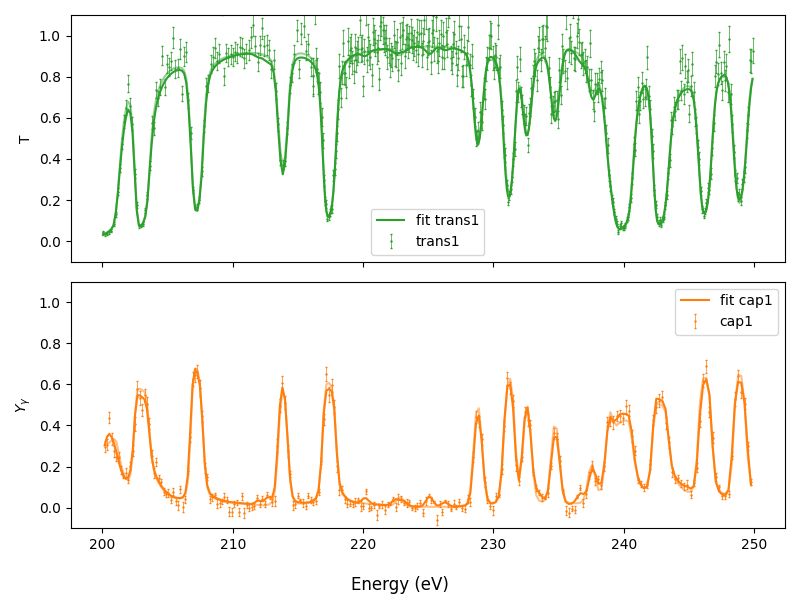

In [11]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=[], true=datasets)
fig.tight_layout()

In [29]:
Ta_pair.resonance_ladder # number of res true

,E,Gg,Gn1,J,J_ID,varyE,varyGg,varyGn1
0,213.859606,65.924364,20.052171,3.0,1,0.0,0.0,0.0
1,231.235012,67.320559,35.290538,3.0,1,0.0,0.0,0.0
2,234.744005,65.456164,9.999808,3.0,1,0.0,0.0,0.0
3,239.922879,62.801775,216.193361,3.0,1,0.0,0.0,0.0
4,242.805544,62.041675,119.472387,3.0,1,0.0,0.0,0.0
5,200.422894,64.127932,229.145093,4.0,2,0.0,0.0,0.0
6,203.002318,65.509512,82.642927,4.0,2,0.0,0.0,0.0
7,207.23553,61.920998,36.541033,4.0,2,0.0,0.0,0.0
8,217.403218,63.627263,53.124923,4.0,2,0.0,0.0,0.0
9,222.839832,65.168223,0.607379,4.0,2,0.0,0.0,0.0


In [12]:
final_fb_output.par

,E,Gg,Gn1,Gn2,Gn3,varyE,varyGg,varyGn1,varyGn2,varyGn3,J_ID
0,200.421272,77.477416,134.603779,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,200.137159,40.878087,228.870097,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,202.310305,11.410579,0.462361,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,202.991883,68.638948,103.010754,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,206.879774,54.548143,0.100882,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
5,207.257640,65.081310,44.991444,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
6,211.985965,30.497089,0.201961,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
7,212.709657,24.405264,0.389829,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
8,213.839460,63.936888,22.332012,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
9,218.379607,54.222803,0.135498,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [13]:
final_fb_output.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,200.432205,71.386591,115.623722,1.0,1.0,1.0,1.0
1,200.166512,48.045422,241.790351,1.0,1.0,1.0,1.0
2,202.307056,12.362181,0.444983,1.0,1.0,1.0,1.0
3,202.991756,68.358650,103.245439,1.0,1.0,1.0,1.0
4,206.895336,51.433481,0.101188,1.0,1.0,1.0,1.0
5,207.257885,65.250331,44.968810,1.0,1.0,1.0,1.0
6,211.983683,21.112989,0.308003,1.0,1.0,1.0,1.0
7,212.701497,18.598521,0.520235,1.0,1.0,1.0,1.0
8,213.839408,63.975657,22.328176,1.0,1.0,1.0,1.0
9,218.387946,46.249515,0.131475,1.0,1.0,1.0,1.0


# AutoFit Module

# Elim Module

In [14]:
settings = {
    'path_to_SAMMY_exe': '/home/fire/SAMMY/sammy/build/install/bin/sammy',
    'path_to_SAMMY_temps': './sammy_temps/',
    'keep_runDIR_SAMMY': True,
    'shell_SAMMY': 'bash',
    'delta_chi2_per_res': 28
}

keep_fixed = True
case_id = 0

delta_chi2_allowed = settings['delta_chi2_per_res']
# save_to_folder = './proc_cases/'

In [21]:
import importlib

# defining a start ladder to eliminate from

from ATARI.AutoFit import chi2_eliminator

importlib.reload(chi2_eliminator)
# Re-import the function from the reloaded module

start_ladder = final_fb_output.par_post
# side resonances - keep empty
side_resonances_df = pd.DataFrame()

# defining rto & inputs

elim_rto = sammy_classes.SammyRunTimeOptions(
    sammyexe = settings['path_to_SAMMY_exe'],
    options = {"Print":   True,
                "bayes":   False,
                "keep_runDIR": settings['keep_runDIR_SAMMY'],
                "sammy_runDIR": f"sammy_RD_{case_id}"
                }
)

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.1
    )

# defining the elim_opts
elim_opts = chi2_eliminator.elim_OPTs(chi2_allowed = delta_chi2_allowed,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 20,
                                      deep_fit_step_thr = 0.001,
                                      start_fudge_for_deep_stage = 0.1
                                      )

In [22]:
elimi = chi2_eliminator.eliminator_by_chi2(rto=elim_rto,
                 sammyINPyw = elim_sammyINPyw , 
                 options = elim_opts
)


In [23]:
# a try to fit using wrapper - note varying parameters are set in start_ladder
unique_combinations = start_ladder[['varyE', 'varyGg', 'varyGn1']].drop_duplicates()
print(unique_combinations)

sammyOUT, fit_time = elimi.fit_YW_by_ig(ladder_df = start_ladder,
                                        max_steps=10,
                                        step_threshold=0.0001)

    varyE  varyGg  varyGn1
0     1.0     1.0      1.0
1     1.0     1.0      1.0
2     1.0     1.0      1.0
3     1.0     1.0      1.0
4     1.0     1.0      1.0
5     1.0     1.0      1.0
6     1.0     1.0      1.0
7     1.0     1.0      1.0
8     1.0     1.0      1.0
9     1.0     1.0      1.0
10    1.0     1.0      1.0
11    1.0     1.0      1.0
12    1.0     1.0      1.0
13    1.0     1.0      1.0
14    1.0     1.0      1.0
15    1.0     1.0      1.0
16    1.0     1.0      1.0
17    1.0     1.0      1.0
18    1.0     1.0      1.0
19    1.0     1.0      1.0
20    1.0     1.0      1.0
21    1.0     1.0      1.0
22    1.0     1.0      1.0
23    1.0     1.0      1.0
24    1.0     1.0      1.0
25    1.0     1.0      1.0
26    1.0     1.0      1.0
27    1.0     1.0      1.0
28    1.0     1.0      1.0
29    1.0     1.0      1.0
30    1.0     1.0      1.0
31    1.0     1.0      1.0
32    1.0     1.0      1.0
33    1.0     1.0      1.0
34    1.0     1.0      1.0
35    1.0     1.0      1.0
3

In [24]:
# now let's eliminate one by one - using the simplified alg - and note  1) allowing to fit all during the deep fit stage
hist = elimi.eliminate(ladder_df=sammyOUT.par_post)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 20


Input ladder:
             E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0   200.433146   71.270515  115.229932    1.0     1.0      1.0   1.0
1   200.165044   47.938023  242.504982    1.0     1.0      1.0   1.0
2   202.306606   12.364035    0.445045    1.0     1.0      1.0   1.0
3   202.991723   68.396766  103.206010    1.0     1.0      1.0   1.0
4   206.897032   51.427804    0.101190    1.0     1.0      1.0   1.0
5   207.257880   65.230465   44.964608    1.0     1.0      1.0   1.0
6   211.983646   21.100492    0.307969    1.0     1.0      1.0   1.0
7   212.701487   18.589908    0.520213    1.0     1.0      1.0   1.0
8   213.839406   63.975098   22.326219    1.0     1.0      1.0   1.0
9   218.388119   46.235630    0.131467    1.0     1.0      1.0   1.0
10  220.155633    8.856826    0.459011    1.0     1.0      1.

In [31]:
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
print('Final ladder:')
print(hist.ladder_OUT)
print(hist.elimination_history.keys())

Eliminated from 47 res -> 20
Final ladder:
             E          Gg         Gn1  Gn2  Gn3  varyE  varyGg  varyGn1  \
0   200.446186   62.491173   99.391807  0.0  0.0    1.0     1.0      1.0   
1   200.190835   56.483625  254.003090  0.0  0.0    1.0     1.0      1.0   
2   202.986535   71.782087  103.498336  0.0  0.0    1.0     1.0      1.0   
3   207.227446   77.546746   49.479442  0.0  0.0    1.0     1.0      1.0   
4   212.649718   29.172929    0.566048  0.0  0.0    1.0     1.0      1.0   
5   213.839382   66.170058   22.219378  0.0  0.0    1.0     1.0      1.0   
6   222.767692  586.518878    1.197216  0.0  0.0    1.0     1.0      1.0   
7   225.102024   12.233463    0.795726  0.0  0.0    1.0     1.0      1.0   
8   228.829719   45.670342   14.748604  0.0  0.0    1.0     1.0      1.0   
9   231.202807   56.706345   37.665858  0.0  0.0    1.0     1.0      1.0   
10  232.584655  174.731899   14.054142  0.0  0.0    1.0     1.0      1.0   
11  234.759882   25.189052   10.333682  0.0  

In [50]:
final_fb_output.pw_post

[              E    exp_xs  exp_xs_unc   theo_xs  theo_xs_bayes  exp_trans  \
 0    200.176298  0.297067    0.025550  0.304491            NaN        NaN   
 1    200.354155  0.306903    0.025428  0.344834            NaN        NaN   
 2    200.532249  0.437437    0.026025  0.359502            NaN        NaN   
 3    200.710580  0.333333    0.029188  0.343732            NaN        NaN   
 4    200.889150  0.274149    0.026011  0.313303            NaN        NaN   
 ..          ...       ...         ...       ...            ...        ...   
 232  248.785641  0.639359    0.030064  0.611912            NaN        NaN   
 233  249.032087  0.564356    0.030872  0.608002            NaN        NaN   
 234  249.278900  0.506757    0.028885  0.508726            NaN        NaN   
 235  249.526080  0.299213    0.020297  0.281227            NaN        NaN   
 236  249.773628  0.123175    0.014564  0.111975            NaN        NaN   
 
      exp_trans_unc  theo_trans  theo_trans_bayes  
 0        

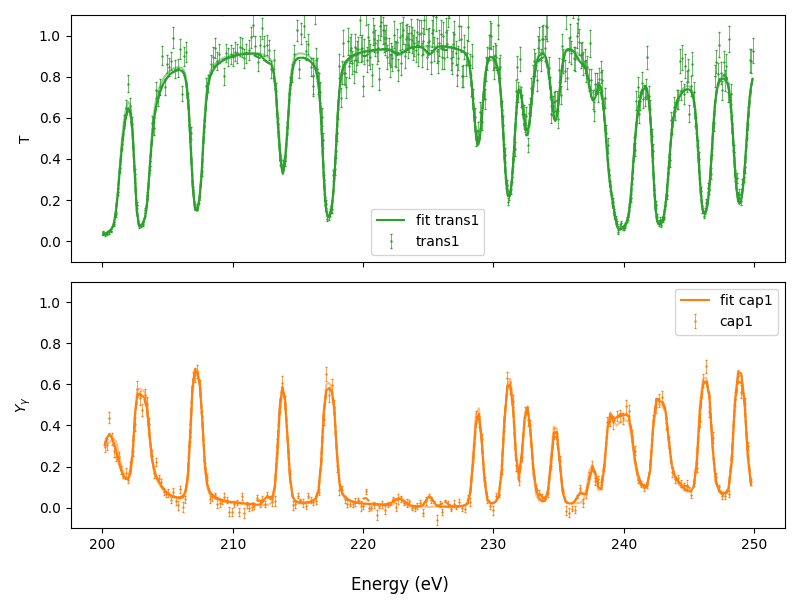

In [51]:
# hist.ladder_OUT
minkey = min(hist.elimination_history.keys())

outfit = hist.elimination_history[minkey]['selected_ladder_chars'].pw
# outfit
fig = plot(datasets, experiments, fits=outfit, priors=final_fb_output.pw_post, true=datasets)
fig.tight_layout()

In [ ]:

# now let's eliminate one by one - using the simplified alg - and note 2) allowing to fit only E and Gn1 during the deep fit stage
